# Libraries

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
from PIL import Image, ImageEnhance


# Paths

In [26]:
base_path = r"C:\Users\laura\OneDrive - Danmarks Tekniske Universitet\Dokumenter\AS DTU\FALL 2024 DTU\Perception for Autonomous Systems\Final project\34759_final_project_raw\34759_final_project_raw\calib"
path_cam2 = os.path.join(base_path, "image_02", "data")
path_cam3 = os.path.join(base_path, "image_03", "data")

# Get all image paths
cam2 = sorted(glob.glob(os.path.join(path_cam2, "*.png")))
cam3 = sorted(glob.glob(os.path.join(path_cam3, "*.png")))

# # Select the number of images to use
# num_images = 19

# # Select only the first 3 images
# cam2 = cam2[:num_images]
# cam3 = cam3[:num_images]

print(f"Found {len(cam2)} images for Camera 2 and {len(cam3)} for Camera 3.")

Found 19 images for Camera 2 and 19 for Camera 3.


# Data preparation

In [27]:
# Boxes x, y, w, h
roi2 = [[130, 120, 180, 210], [370, 170, 110, 140], [460, 70, 170, 75], [510, 270, 90, 120], [490, 385, 180, 130], [680, 290, 90, 120], [790, 130, 130, 100], [800, 300, 100, 120], [1000, 60, 200, 100], [1100, 250, 100, 130], [1000, 380, 144, 70], [1240, 160, 75, 280], [1320, 180, 70, 170]]
roi3 = [[40, 120, 240, 230], [300, 170, 130, 150], [372, 83, 164, 77], [450, 260, 90, 120], [380, 335, 280, 190], [600, 290, 90, 120], [680, 80, 230, 160], [690, 250, 200, 180], [890, 10, 300, 160], [990, 240, 100, 120], [895, 365, 138, 72], [1136, 157, 58, 262], [1200, 160, 66, 180]]

gridsizes = [(7,11), (7,11), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,15), (5,7)]

# Individual calibration

## Calibration function

In [28]:
def calibrate_camera(img_path1, img_path2, roi1, roi2, gridsizes):
    # Arrays to store real-world points and image points
    objpoints = []  # 3D points in real-world space
    imgpoints1 = []  # 2D points in the image from camera 1
    imgpoints2 = []  # 2D points in the image from camera 2

    # Store detected corners to avoid duplicates
    detected_corners1 = []
    detected_corners2 = []

    # Images to show all detections
    all_corners_img1 = None
    all_corners_img2 = None

    for i, (fname1, fname2) in enumerate(zip(img_path1, img_path2)):
        
        # Read images
        img1_original = cv2.imread(fname1)
        img2_original = cv2.imread(fname2)
        h, w = img1_original.shape[:2]
        
        # Resize images to improve detection
        img1_resized = cv2.resize(img1_original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        img2_resized = cv2.resize(img2_original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Convert to grayscale
        gray1 = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

        # Enhance contrast and brightness
        alpha = 1.8  # Contrast control
        beta = 10    # Brightness control
        gray1 = cv2.convertScaleAbs(gray1, alpha=alpha, beta=beta)
        gray2 = cv2.convertScaleAbs(gray2, alpha=alpha, beta=beta)

        # Create base images for combined detection visualization
        if all_corners_img1 is None:
            all_corners_img1 = img1_original.copy()
            all_corners_img2 = img2_original.copy()

        for j, (box1, box2, size) in enumerate(zip(roi1, roi2, gridsizes)):
            
            # Prepare real-world 3D points
            objp = np.zeros((size[0] * size[1], 3), np.float32)
            objp[:, :2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1, 2)
            objp *= 10e-2  # Square size in meters (10 cm)

            # Create masks for ROIs
            mask1 = np.zeros_like(gray1)
            mask2 = np.zeros_like(gray2)
            mask1[box1[1]*2:box1[1]*2+box1[3]*2, box1[0]*2:box1[0]*2+box1[2]*2] = 255
            mask2[box2[1]*2:box2[1]*2+box2[3]*2, box2[0]*2:box2[0]*2+box2[2]*2] = 255

            gray1_masked = cv2.bitwise_and(gray1, mask1)
            gray2_masked = cv2.bitwise_and(gray2, mask2)

            # Detect chessboards
            ret1, corners1 = cv2.findChessboardCorners(gray1_masked, size)
            ret2, corners2 = cv2.findChessboardCorners(gray2_masked, size)


            if ret1 and ret2:
                # Refine corners
                corners1 = cv2.cornerSubPix(
                    gray1_masked, corners1, (7, 7), (-1, -1),
                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                )
                corners2 = cv2.cornerSubPix(
                    gray2_masked, corners2, (7, 7), (-1, -1),
                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                )

                # Scale corners back to original size
                corners1 /= 2
                corners2 /= 2

                # Avoid duplicates in corners1
                is_duplicate1 = False
                for detected in detected_corners1:
                    if len(corners1) == len(detected):  # Compare sizes
                        if np.allclose(corners1, detected, atol=5):  # Check proximity
                            is_duplicate1 = True
                            break

                if not is_duplicate1:
                    detected_corners1.append(corners1)
                    cv2.drawChessboardCorners(all_corners_img1, size, corners1, ret1)
                    objpoints.append(objp)
                    imgpoints1.append(corners1)

                # Avoid duplicates in corners2
                is_duplicate2 = False
                for detected in detected_corners2:
                    if len(corners2) == len(detected):  # Compare sizes
                        if np.allclose(corners2, detected, atol=5):  # Check proximity
                            is_duplicate2 = True
                            break

                if not is_duplicate2:
                    detected_corners2.append(corners2)
                    cv2.drawChessboardCorners(all_corners_img2, size, corners2, ret2)
                    imgpoints2.append(corners2)

    # Plot results
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.title("All Chessboards Camera Left")
    plt.imshow(cv2.cvtColor(all_corners_img1, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("All Chessboards Camera Right")
    plt.imshow(cv2.cvtColor(all_corners_img2, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

    return objpoints, imgpoints1, imgpoints2


## Calibration function execution

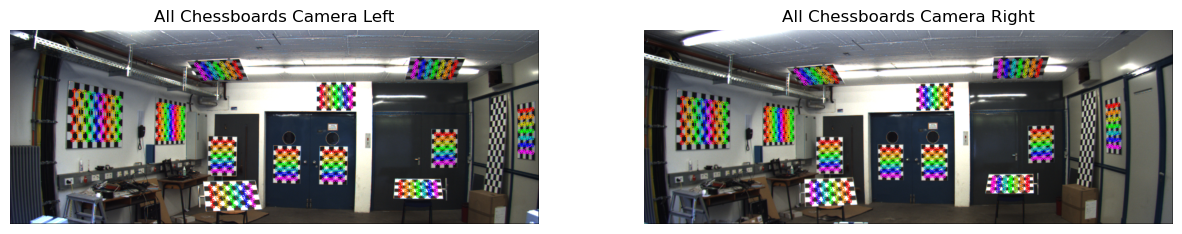

In [29]:

objpoints, imgpoints1, imgpoints2 = calibrate_camera(cam2, cam3, roi2, roi3, gridsizes)


## Calibration results for both cameras

In [30]:
print(f"Length of objpoints: {len(objpoints)}")
print(f"Length of imgpoints1: {len(imgpoints1)}")
print(f"Length of imgpoints2: {len(imgpoints2)}")

Length of objpoints: 13
Length of imgpoints1: 13
Length of imgpoints2: 13


In [31]:
# Verify and filter valid points
valid_indices = [i for i in range(len(objpoints)) if len(imgpoints1[i]) > 0 and len(imgpoints2[i]) > 0]

# Filter lists to keep only valid indices
objpoints = [objpoints[i] for i in valid_indices]
imgpoints1 = [imgpoints1[i] for i in valid_indices]
imgpoints2 = [imgpoints2[i] for i in valid_indices]

# Ensure there are enough points for calibration
if len(objpoints) < 5:  # Calibration requires at least 5 valid points
    raise RuntimeError("Not enough valid points for camera calibration.")

# Read the first images from both cameras (cam2 and cam3)
for img_path2, img_path3 in zip(cam2, cam3):
    img2 = cv2.imread(img_path2)  # Camera 2 image
    img3 = cv2.imread(img_path3)  # Camera 3 image

    # Get the image size (used for stereo calibration)
    img_size_2 = (img2.shape[1], img2.shape[0])  # (width, height)
    img_size_3 = (img3.shape[1], img3.shape[0])  # (width, height)

# Perform the calibration
ret2, K2, D2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints, imgpoints1, img_size_2, None, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6))
if not ret2:
     raise RuntimeError("Camera 2 calibration failed.")

ret3, K3, D3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints, imgpoints2, img_size_3, None, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6))
if not ret3:
    raise RuntimeError("Camera 3 calibration failed.")

# If calibration is successful, print the results without scientific notation
np.set_printoptions(suppress=True, precision=3)

print(f"Camera 2 Calibration Results:\n K2  =\n {K2}, \n D2 =\n {D2}")
print(f"Camera 3 Calibration Results: \n K3 =\n {K3}, \n D3 =\n {D3}")
print(f"Camera 2 tvecs: \n", tvecs2 [0])
print(f"Camera 3 tvecs: \n", tvecs3 [0])
print(f"Camera 2 rvecs: \n", rvecs2 [0])
print(f"Camera 3 rvecs: \n", rvecs3 [0])
print(f"Camera 2 error: {ret2:.3f}")
print(f"Camera 3 error: {ret3:.3f}")

# Calculate the total reprojection error for each camera
total_error2 = 0
for i in range(len(objpoints)):
    imgpoints2_reproj, _ = cv2.projectPoints(objpoints[i], rvecs2[i], tvecs2[i], K2, D2)
    error2 = cv2.norm(imgpoints1[i], imgpoints2_reproj, cv2.NORM_L2) / len(imgpoints2_reproj)
    total_error2 += error2

total_error3 = 0
for i in range(len(objpoints)):
    imgpoints3_reproj, _ = cv2.projectPoints(objpoints[i], rvecs3[i], tvecs3[i], K3, D3)
    error3 = cv2.norm(imgpoints2[i], imgpoints3_reproj, cv2.NORM_L2) / len(imgpoints3_reproj)
    total_error3 += error3

print(f"Camera 2 Total Reprojection Error: {total_error2:.3f}")
print(f"Camera 3 Total Reprojection Error: {total_error3:.3f}")


Camera 2 Calibration Results:
 K2  =
 [[964.457   0.    710.468]
 [  0.    968.531 231.04 ]
 [  0.      0.      1.   ]], 
 D2 =
 [[-0.36   0.188 -0.001 -0.002 -0.052]]
Camera 3 Calibration Results: 
 K3 =
 [[912.044   0.    702.91 ]
 [  0.    924.032 222.028]
 [  0.      0.      1.   ]], 
 D3 =
 [[-0.345  0.183  0.001 -0.002 -0.069]]
Camera 2 tvecs: 
 [[-2.514]
 [ 0.277]
 [ 3.919]]
Camera 3 tvecs: 
 [[-3.116]
 [ 0.383]
 [ 3.977]]
Camera 2 rvecs: 
 [[ 1.037]
 [-1.091]
 [-1.25 ]]
Camera 3 rvecs: 
 [[ 1.025]
 [-1.127]
 [-1.26 ]]
Camera 2 error: 0.187
Camera 3 error: 0.197
Camera 2 Total Reprojection Error: 0.393
Camera 3 Total Reprojection Error: 0.372


# Undistorting camera 2 and camera 3

In [9]:
# Loop through the images for both cameras
for img_path2, img_path3 in zip(cam2, cam3):
    # Read images from both cameras
    img2 = cv2.imread(img_path2)  # Image from camera 2
    img3 = cv2.imread(img_path3)  # Image from camera 3

    # Check if images are loaded correctly
    if img2 is None or img3 is None:
        print(f"Error loading images: {img_path2} or {img_path3}")
        continue  # Skip to the next pair of images

    # Get the image file names
    img_name2 = os.path.basename(img_path2)  # Name of the image from camera 2
    img_name3 = os.path.basename(img_path3)  # Name of the image from camera 3

    # Get image size (width, height)
    img_size_2 = (img2.shape[1], img2.shape[0])  # (width, height)
    img_size_3 = (img3.shape[1], img3.shape[0])  # (width, height)

    # Undistort images using the calibration parameters 
    undistorted_img2 = cv2.undistort(img2, K2, D2)
    undistorted_img3 = cv2.undistort(img3, K3, D3)

    # Display the original and undistorted images for comparison
    # plt.figure(figsize=(15, 7))

    # # Original Image from Camera 2
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    # plt.title(f"Original Image - Camera 2\n{img_name2}")  # Show the image name
    # plt.axis('off')

    # # Undistorted Image from Camera 2
    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(undistorted_img2, cv2.COLOR_BGR2RGB))
    # plt.title(f"Undistorted Image - Camera 2\n{img_name2}")  # Show the image name
    # plt.axis('off')

    # plt.show()

    # # Display the original and undistorted images for Camera 3
    # plt.figure(figsize=(15, 7))

    # # Original Image from Camera 3
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    # plt.title(f"Original Image - Camera 3\n{img_name3}")  # Show the image name
    # plt.axis('off')

    # # Undistorted Image from Camera 3
    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(undistorted_img3, cv2.COLOR_BGR2RGB))
    # plt.title(f"Undistorted Image - Camera 3\n{img_name3}")  # Show the image name
    # plt.axis('off')

    # plt.show()


In [32]:
# Get optimal camera matrix
frameSize = (img2.shape[1], img2.shape[0])
optimal_camera_matrix2, roi2 = cv2.getOptimalNewCameraMatrix(K2, D2, frameSize, 1, frameSize)
optimal_camera_matrix3, roi3 = cv2.getOptimalNewCameraMatrix(K3, D3, frameSize, 1, frameSize)

# Print the optimal camera matrix 
print(f"Optimal Camera Matrix 2: \n {optimal_camera_matrix2}")
print(f"Optimal Camera Matrix 3: \n {optimal_camera_matrix3}")


Optimal Camera Matrix 2: 
 [[746.658   0.    708.096]
 [  0.    754.883 227.927]
 [  0.      0.      1.   ]]
Optimal Camera Matrix 3: 
 [[648.526   0.    695.195]
 [  0.    664.666 217.709]
 [  0.      0.      1.   ]]


# Stereo calibration (NOT WORKING)

In [38]:

def undistort_points(imgpoints, new_camera_matrix, dist_coeffs, camera_matrix):
    # Apply undistortion to the image points
    new_points = [cv2.undistortPoints(pts, camera_matrix, dist_coeffs, None, new_camera_matrix) for pts in imgpoints]
    return new_points

In [39]:
def stereo_calibrate(imgpoints_l_undistorted, imgpoints_r_undistorted, objpoints, K2, D2, K3, D3, img_size_2, img_size_3):
    # Initialize the rotation and translation vectors for stereo calibration
    flags = cv2.CALIB_FIX_INTRINSIC
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
    
    # Stereo calibration
    ret, K2_stereo, D2_stereo, K3_stereo, D3_stereo, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_l_undistorted, imgpoints_r_undistorted, K2, D2, K3, D3, img_size_2, criteria=criteria, flags=flags
    )

    # Check if calibration was successful
    if not ret:
        raise RuntimeError("Stereo calibration failed.")

    print(f"Stereo Calibration error: {ret:.3f}")
    print(f"Stereo Calibration Results: \n")
    print(f"Camera 2 Stereo Matrix: \n{K2_stereo}")
    print(f"Camera 3 Stereo Matrix: \n{K3_stereo}")
    print(f"Rotation Matrix: \n{R}")
    print(f"Translation Vector: \n{T}")
    print(f"Essential Matrix: \n{E}")
    print(f"Fundamental Matrix: \n{F}")

    return K2_stereo, D2_stereo, K3_stereo, D3_stereo, R, T, E, F


In [40]:
# Undistort the points for both left and right camera
imgpoints_2_undistorted = undistort_points(imgpoints1, optimal_camera_matrix2, D2, K2)
imgpoints_3_undistorted = undistort_points(imgpoints2, optimal_camera_matrix3, D3, K3)

# Perform stereo calibration using undistorted points
K2_stereo, D2_stereo, K3_stereo, D3_stereo, R, T, E, F = stereo_calibrate(
    imgpoints_2_undistorted, imgpoints_3_undistorted, objpoints, K2, D2, K3, D3, img_size_2, img_size_3
)



Stereo Calibration error: 15.576
Stereo Calibration Results: 

Camera 2 Stereo Matrix: 
[[964.457   0.    710.468]
 [  0.    968.531 231.04 ]
 [  0.      0.      1.   ]]
Camera 3 Stereo Matrix: 
[[912.044   0.    702.91 ]
 [  0.    924.032 222.028]
 [  0.      0.      1.   ]]
Rotation Matrix: 
[[ 0.996  0.004  0.085]
 [-0.019  0.985  0.171]
 [-0.083 -0.172  0.982]]
Translation Vector: 
[[-1.376]
 [-1.175]
 [ 0.884]]
Essential Matrix: 
[[ 0.115 -0.669 -1.305]
 [ 0.766 -0.233  1.426]
 [ 1.197 -1.351 -0.135]]
Fundamental Matrix: 
[[ 0.    -0.    -0.042]
 [ 0.    -0.     0.031]
 [ 0.03  -0.025  1.   ]]
